In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('female_france.csv')
df.query("Age < 95", inplace=True)



---


1. Exploratory Data Analysis


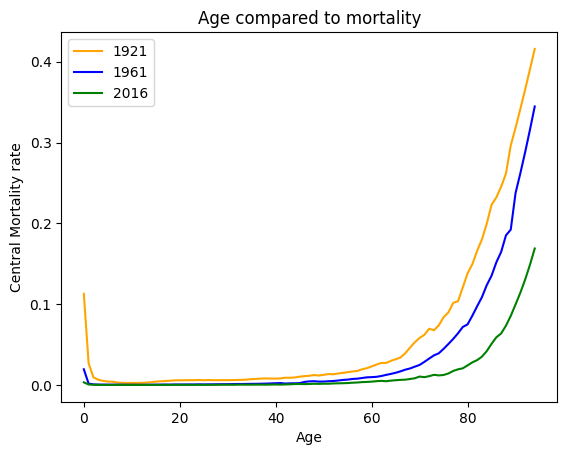

In [ ]:
obj = {
    'time_periods': [1921, 1961, 2016],
    'colours': ['orange', 'blue', 'green']
}

for i in range(3):
    filtered_df = df[df['Year'] == obj['time_periods'][i]]
    plt.plot(filtered_df['Age'], filtered_df['mx'], color=obj['colours'][i], label=obj['time_periods'][i])

plt.legend()

plt.xlabel('Age')
plt.ylabel('Central Mortality rate')
plt.title('Age compared to mortality')

plt.show()



---


2. Benchmark Model

In [ ]:
end_year = 1990
end_year_val = 2000

train_years = [i for i in range(1921,end_year)]
val_years = [i for i in range(end_year,end_year_val)]
test_years = [i for i in range(end_year_val,2021)]

In [ ]:
ages = {
    'ages': [20, 50, 80],
    'colours': ['blue', 'green', 'red', 'orange'],
    'labels': ['train', 'test', 'benchmark', 'val']
}

age_considered = ages['ages'][2]

# obtaining final central mortality rates in training data for use in benchmark model
final_mortality_rates = {}
for age in range(0, 95):
    final_mortality_rates[str(age)] = df.query(f"Age == {age} and Year == {end_year}")['mx'].tolist()[0]

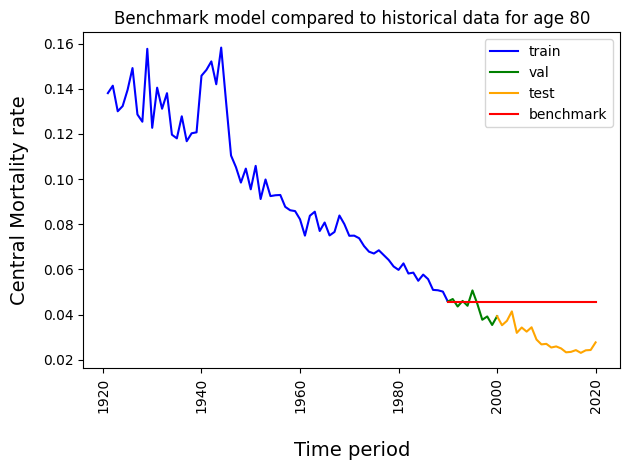

In [ ]:
train_df = df[df['Age'] == age_considered]
train_df = train_df[train_df['Year'].isin(train_years + [end_year])]

val_df = df[df['Age'] == age_considered]
val_df = val_df[val_df['Year'].isin(val_years + [end_year_val])]

test_df = df[df['Age'] == age_considered]
test_df = test_df[test_df['Year'].isin(test_years)]

benchmark_df = df[df['Age'] == age_considered]
benchmark_df = benchmark_df[benchmark_df['Year'].isin(val_years + test_years)]

num_years_needed_to_project = len(val_years + test_years)
num_years_in_val_set = len(val_years)
num_years_in_test_set = len(test_years)

# plotting historical data, true data past end_year and benchmark past end_year
plt.plot(train_df['Year'], train_df['mx'], color=ages['colours'][0], label=ages['labels'][0])
plt.plot(val_df['Year'], val_df['mx'], color=ages['colours'][1], label=ages['labels'][3])
plt.plot(test_df['Year'], test_df['mx'], color=ages['colours'][3], label=ages['labels'][1])

plt.plot(benchmark_df['Year'], [final_mortality_rates[str(age_considered)]] * num_years_needed_to_project, color=ages['colours'][2], label=ages['labels'][2])


plt.legend()
plt.xlabel('Time period', fontsize=14, labelpad=20)
plt.ylabel('Central Mortality rate', fontsize=14, labelpad=10)
plt.title(f'Benchmark model compared to historical data for age {age_considered}')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [ ]:
import math

rmse_val = 0
rmse_test = 0

# average rmse across all age groups
for age in df['Age'].unique():
    y_true_val = df[df['Year'].isin(val_years)].query(f'Age == {str(age)}')['mx'].tolist()
    y_true_test = df[df['Year'].isin(test_years)].query(f'Age == {str(age)}')['mx'].tolist()
    y_pred = final_mortality_rates[str(age)]

    if math.isnan(y_pred):
      continue

    for i in range(len(y_true_val)):
        if (y_true_val[i] == 0):
          continue

        rmse_val += np.mean((y_pred - y_true_val[i]) ** 2)

    for i in range(len(y_true_val)):
        if (y_true_val[i] == 0):
          continue

        rmse_test += np.mean((y_pred - y_true_test[i]) ** 2)

rmse_val = math.sqrt(rmse_val / (len(df["Age"].unique()) * num_years_in_val_set))
rmse_test = math.sqrt(rmse_test / (len(df["Age"].unique()) * num_years_in_test_set))

print(f'Average root mean squared error for val set is: {rmse_val}')
print(f'Average root mean squared error for test set is: {rmse_test}')

********************
Average root mean squared error for val set is: 0.005930875128467441
Average root mean squared error for test set is: 0.010684332818169957




---

2.2 Preprocessing before training deep-learning models

In [ ]:
end_year = 1990

train_years = [float(i) for i in range(1921,end_year)]
val_years = [float(i) for i in range(end_year,2010)]
test_years = [float(i) for i in range(2010,2021)]

In [ ]:
df = df.drop(['lx'], axis=1) # correlation between lx and Lx is 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaling_cols = ['Age', 'ax', 'lx', 'dx', 'Lx', 'Tx', 'ex']

mm = MinMaxScaler()

for col in df.columns:
  if col in scaling_cols:
    df[col] = mm.fit_transform(df[[col]])

In [ ]:
train_df = df.query('Year in (@train_years)')
val_df = val_df.query('Year in (@val_years)')
test_df = df.query('Year in (@test_years)')


---
Apply min-max scaling to Year column


In [ ]:
min_year = min(train_years)
max_year = max(test_years)

def scale_year(year):
    return (year - min_year) / (max_year - min_year)

train_df['Year'] = train_df['Year'].apply(scale_year)
val_df['Year'] = val_df['Year'].apply(scale_year)
test_df['Year'] = test_df['Year'].apply(scale_year)

<ipython-input-13-95ed03c94070>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Year'] = train_df['Year'].apply(scale_year)
<ipython-input-13-95ed03c94070>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Year'] = val_df['Year'].apply(scale_year)
<ipython-input-13-95ed03c94070>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [ ]:
X_train = train_df.drop(['mx'], axis=1)
y_train = train_df['mx']

X_val = val_df.drop(['mx'], axis=1)
y_val = val_df['mx']

X_test = test_df.drop(['mx'], axis=1)
y_test = test_df['mx']



---


3. Simple RNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

from keras import metrics

In [ ]:
simple_rnn_model = Sequential([
    SimpleRNN(units=30, input_shape=(X_train.shape[1], 1)),
    Dense(units=15, activation='relu'),
    Dense(units=1)
])

simple_rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.RootMeanSquaredError()])
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
simple_rnn_model.fit(X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/100
205/205 [==============================] - 5s 9ms/step - loss: 3.3524e-04 - root_mean_squared_error: 0.0183 - val_loss: 3.5209e-04 - val_root_mean_squared_error: 0.0188
Epoch 2/100
205/205 [==============================] - 2s 8ms/step - loss: 9.2398e-05 - root_mean_squared_error: 0.0096 - val_loss: 1.2974e-04 - val_root_mean_squared_error: 0.0114
Epoch 3/100
205/205 [==============================] - 2s 9ms/step - loss: 5.8263e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.0051e-04 - val_root_mean_squared_error: 0.0200
Epoch 4/100
205/205 [==============================] - 3s 13ms/step - loss: 4.3971e-05 - root_mean_squared_error: 0.0066 - val_loss: 4.7052e-05 - val_root_mean_squared_error: 0.0069
Epoch 5/100
205/205 [==============================] - 2s 8ms/step - loss: 4.6802e-05 - root_mean_squared_error: 0.0068 - val_loss: 9.1428e-05 - val_root_mean_squared_error: 0.0096
Epoch 6/100
205/205 [==============================] - 2s 8ms/step - loss: 4.4875e-05 - root_m

In [ ]:
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dense (Dense)               (None, 15)                465       
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1441 (5.63 KB)
Trainable params: 1441 (5.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_loss = simple_rnn_model.evaluate(X_train, y_train)
val_loss = simple_rnn_model.evaluate(X_val, y_val)
test_loss = simple_rnn_model.evaluate(X_test, y_test)

print(f'Train loss: {train_loss}')
print(f'Val loss: {val_loss}')
print(f'Test loss: {test_loss}')

33/33 [==============================] - 0s 4ms/step - loss: 3.4348e-05 - root_mean_squared_error: 0.0059
Train loss: [2.044175380433444e-05, 0.004521255847066641]
Val loss: [2.6274859919794835e-05, 0.0051259007304906845]
Test loss: [3.434758764342405e-05, 0.005860681179910898]



---

4. Convolutional Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from keras import metrics

In [ ]:
conv_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1)
])

conv_model.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics.RootMeanSquaredError()])
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
conv_model.fit(X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/100
205/205 [==============================] - 4s 7ms/step - loss: 6.2162e-04 - root_mean_squared_error: 0.0249 - val_loss: 4.4655e-05 - val_root_mean_squared_error: 0.0067
Epoch 2/100
205/205 [==============================] - 1s 4ms/step - loss: 4.3202e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.4551e-05 - val_root_mean_squared_error: 0.0038
Epoch 3/100
205/205 [==============================] - 1s 4ms/step - loss: 2.5709e-05 - root_mean_squared_error: 0.0051 - val_loss: 1.9602e-05 - val_root_mean_squared_error: 0.0044
Epoch 4/100
205/205 [==============================] - 1s 4ms/step - loss: 3.0747e-05 - root_mean_squared_error: 0.0055 - val_loss: 5.1891e-06 - val_root_mean_squared_error: 0.0023
Epoch 5/100
205/205 [==============================] - 1s 4ms/step - loss: 2.0093e-05 - root_mean_squared_error: 0.0045 - val_loss: 1.4467e-05 - val_root_mean_squared_error: 0.0038
Epoch 6/100
205/205 [==============================] - 1s 4ms/step - loss: 1.3910e-05 - root_me

In [ ]:
train_loss = conv_model.evaluate(X_train, y_train)
val_loss = conv_model.evaluate(X_val, y_val)
test_loss = conv_model.evaluate(X_test, y_test)

print(f'Train loss: {train_loss}')
print(f'Val loss: {val_loss}')
print(f'Test loss: {test_loss}')

33/33 [==============================] - 0s 6ms/step - loss: 1.3799e-05 - root_mean_squared_error: 0.0037
Train loss: [2.055879303952679e-05, 0.004534180276095867]
Val loss: [5.189103831071407e-06, 0.002277960302308202]
Test loss: [1.3798998224956449e-05, 0.0037147002294659615]




---
5. Hyperparameter tuning of Simple RNN


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import Hyperband

from keras import metrics

<ipython-input-26-e85893f86424>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
def build_model(hp):
    model = Sequential([
        SimpleRNN(hp.Int('rnn_units', min_value=18, max_value=64, step=6), input_shape=(X_train.shape[1], 1)),
        Dense(hp.Int('dense_units_1', min_value=8, max_value=64, step=8), activation='relu'),
        Dense(1)
    ])

    # Define the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 2e-6])

    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=losses.MeanSquaredError(),
                  metrics=[metrics.MeanSquaredError(), metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_mean_squared_error',
    factor=3,
    max_epochs=10,
    directory='tuner_dir',
    project_name='simple_rnn_tuning',
    overwrite=True,
    seed=42
)

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tuner.search(X_train, y_train,
             epochs=3,
             validation_data=(X_val, y_val), callbacks=[es])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal learning rate found: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 00m 22s]
val_mean_squared_error: 3.879114956362173e-06

Best val_mean_squared_error So Far: 3.879114956362173e-06
Total elapsed time: 00h 05m 54s
Optimal learning rate found: 0.001


In [ ]:
train_loss = best_model.evaluate(X_train, y_train)
val_loss = best_model.evaluate(X_val, y_val)
test_loss = best_model.evaluate(X_test, y_test)

print(f'Train loss: {train_loss}')
print(f'Val loss: {val_loss}')
print(f'Test loss: {test_loss}')

33/33 [==============================] - 0s 3ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - root_mean_squared_error: 0.1829
Train loss: [0.051851268857717514, 0.051851268857717514, 0.22770872712135315]
Val loss: [0.036790333688259125, 0.036790333688259125, 0.1918080598115921]
Test loss: [0.033436547964811325, 0.033436547964811325, 0.18285663425922394]


In [ ]:
print(best_hps.get('rnn_units'))
print(best_hps.get('dense_units_1'))

120
48



---
6. Hyperparameter tuning of CNN


In [ ]:
!pip install keras-tuner

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import Hyperband

from keras import metrics

In [ ]:
def build_model(hp):
    model = Sequential([
        Conv1D(hp.Int('conv1_filters', min_value=32, max_value=32, step=8), kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(hp.Int('conv2_filters', min_value=64, max_value=64, step=8), kernel_size=3, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1)
    ])

    # Define the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 1e-4, 1e-5])

    model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=losses.MeanSquaredError(),
                  metrics=[metrics.MeanSquaredError(), metrics.RootMeanSquaredError()])

    return model

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_mean_squared_error',
    factor = 3,
    max_epochs = 10,
    directory='tuner_dir',
    project_name='cnn_tuning',
    overwrite=True,
    seed=42
)

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tuner.search(X_train, y_train,
             epochs=3,
             validation_data=(X_val, y_val), callbacks=[es])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal learning rate found: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)

Trial 5 Complete [00h 00m 07s]
val_mean_squared_error: 1.6272872016998008e-05

Best val_mean_squared_error So Far: 8.163271559169516e-06
Total elapsed time: 00h 00m 32s
Optimal learning rate found: 0.005


In [ ]:
print(best_hps.get('conv1_filters'))
print(best_hps.get('conv2_filters'))

32
64


In [ ]:
train_loss = best_model.evaluate(X_train, y_train)
val_loss = best_model.evaluate(X_val, y_val)
test_loss = best_model.evaluate(X_test, y_test)

print(f'Train loss: {train_loss}')
print(f'Val loss: {val_loss}')
print(f'Test loss: {test_loss}')

33/33 [==============================] - 0s 4ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - root_mean_squared_error: 0.0798
Train loss: [0.01222848892211914, 0.01222848892211914, 0.11058250069618225]
Val loss: [0.006880519445985556, 0.006880519445985556, 0.08294889330863953]
Test loss: [0.006362898740917444, 0.006362898740917444, 0.07976777851581573]
